Path to dataset files: /kaggle/input/cityscapes-pix2pix-dataset


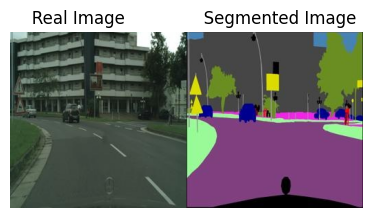

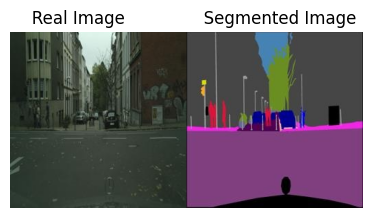

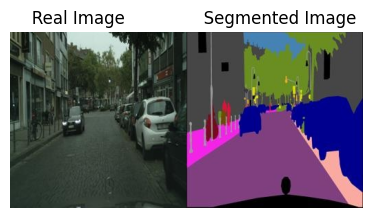

In [1]:
# Author: Sajjad_Heidarinezhad

# Import necessary libraries
import os  # For file and directory operations
import matplotlib.pyplot as plt  # For displaying images
from PIL import Image  # For handling image files
import kagglehub  # Library for interacting with Kaggle datasets

# Download the Cityscapes pix2pix dataset from Kaggle using kagglehub
dataset_path = kagglehub.dataset_download("balraj98/cityscapes-pix2pix-dataset")

# Print the path where the dataset has been downloaded
print("Path to dataset files:", dataset_path)

# Define paths for the training and validation directories within the dataset
train_path = os.path.join(dataset_path, 'train')  # Path to training data
val_path = os.path.join(dataset_path, 'val')  # Path to validation data

# Define a function to display pairs of images from the dataset
def display_image_pairs(data_path, num_samples=3):
    """
    Displays paired images (real and segmented) from the dataset.

    Args:
        data_path (str): Path to the directory containing image pairs.
        num_samples (int): Number of image pairs to display.
    """
    # Check if the specified data path exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"The specified path does not exist: {data_path}")
    
    # List all image files in the directory and sort them
    images = sorted(os.listdir(data_path))
    
    # Loop through the number of samples specified
    for i in range(num_samples):
        # Open the current image using PIL
        image_s = Image.open(os.path.join(data_path, images[i]))
        
        # Create a new figure for the images
        plt.figure(figsize=(10, 5))
        
        # Plot the image in the first subplot
        plt.subplot(1, 2, 1)  # Specify a 1-row, 2-column grid, first subplot
        plt.imshow(image_s)  # Display the image
        plt.title('   Real Image               Segmented Image')  # Set title
        plt.axis('off')  # Hide axes for better visualization
        
        # Show the plot
        plt.show()

# Call the function to display 3 image pairs from the training data
display_image_pairs(train_path, num_samples=3)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from PIL import Image


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:

# Define a DownSample class that inherits from nn.Module
class DownSample(nn.Module):
    """
    A down-sampling block for neural networks, typically used in convolutional architectures.
    The block includes a convolutional layer, optional batch normalization, and a LeakyReLU activation.
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, apply_batchnorm=True):
        """
        Initializes the DownSample block.

        Args:
            in_channels (int): Number of input channels for the convolutional layer.
            out_channels (int): Number of output channels for the convolutional layer.
            kernel_size (int): Size of the convolutional kernel. Default is 4.
            apply_batchnorm (bool): Whether to apply batch normalization after the convolution. Default is True.
        """
        # Initialize the parent class
        super(DownSample, self).__init__()

        # Define a list of layers to include in the block
        layers = [
            # Add a 2D convolutional layer
            nn.Conv2d(
                in_channels,  # Number of input channels
                out_channels,  # Number of output channels
                kernel_size,  # Size of the convolutional kernel
                stride=2,  # Down-sample by reducing the spatial dimensions by a factor of 2
                padding=1,  # Add padding to maintain dimensions before down-sampling
                bias=not apply_batchnorm  # Disable bias if batch normalization is applied
            )
        ]

        # Optionally add batch normalization
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))  # Normalize feature maps for faster convergence

        # Add a LeakyReLU activation function
        layers.append(nn.LeakyReLU(0.2))  # Apply activation with a negative slope of 0.2

        # Combine the layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass for the DownSample block.

        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after applying the layers in the block.
        """
        return self.model(x)  # Pass the input through the sequential layers


In [6]:

# Define an UpSample class that inherits from nn.Module
class UpSample(nn.Module):
    """
    An up-sampling block for neural networks, typically used in convolutional architectures.
    The block includes a transposed convolutional layer, batch normalization, ReLU activation, 
    and optional dropout for regularization.
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, apply_dropout=False):
        """
        Initializes the UpSample block.

        Args:
            in_channels (int): Number of input channels for the transposed convolutional layer.
            out_channels (int): Number of output channels for the transposed convolutional layer.
            kernel_size (int): Size of the convolutional kernel. Default is 4.
            apply_dropout (bool): Whether to apply dropout after the activation. Default is False.
        """
        # Initialize the parent class
        super(UpSample, self).__init__()

        # Define a list of layers to include in the block
        layers = [
            # Add a transposed 2D convolutional layer (used for up-sampling)
            nn.ConvTranspose2d(
                in_channels,  # Number of input channels
                out_channels,  # Number of output channels
                kernel_size,  # Size of the convolutional kernel
                stride=2,  # Up-sample by increasing the spatial dimensions by a factor of 2
                padding=1,  # Add padding to maintain consistent dimensions
                bias=False  # Bias is not needed as batch normalization is applied
            ),
            # Add batch normalization to normalize feature maps for better training stability
            nn.BatchNorm2d(out_channels),
            # Add ReLU activation to introduce non-linearity
            nn.ReLU()
        ]

        # Optionally add dropout for regularization to prevent overfitting
        if apply_dropout:
            layers.append(nn.Dropout(0.5))  # Drop 50% of neurons during training

        # Combine the layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass for the UpSample block.

        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after applying the layers in the block.
        """
        return self.model(x)  # Pass the input through the sequential layers


In [7]:

# Define a Generator class that inherits from nn.Module
class Generator(nn.Module):
    """
    U-Net based Generator model for image-to-image translation tasks.
    The generator consists of down-sampling blocks (encoder), a bottleneck,
    and up-sampling blocks (decoder) with skip connections for better feature preservation.
    """
    def __init__(self):
        """
        Initializes the Generator model by defining its layers.
        """
        super(Generator, self).__init__()

        # Down-sampling (encoder) layers
        self.down1 = DownSample(in_channels=3, out_channels=64, apply_batchnorm=False)  # Input image -> first down-sample block
        self.down2 = DownSample(in_channels=64, out_channels=128)  # Second down-sample block
        self.down3 = DownSample(in_channels=128, out_channels=256)  # Third down-sample block
        self.down4 = DownSample(in_channels=256, out_channels=512)  # Fourth down-sample block
        self.down5 = DownSample(in_channels=512, out_channels=512)  # Fifth down-sample block
        self.down6 = DownSample(in_channels=512, out_channels=512)  # Sixth down-sample block
        self.down7 = DownSample(in_channels=512, out_channels=512)  # Seventh down-sample block
        self.down8 = DownSample(in_channels=512, out_channels=512, apply_batchnorm=False)  # Bottleneck layer without batch normalization

        # Up-sampling (decoder) layers
        self.up1 = UpSample(in_channels=512, out_channels=512, kernel_size=4, apply_dropout=True)  # First up-sample block
        self.up2 = UpSample(in_channels=1024, out_channels=512, kernel_size=4, apply_dropout=True)  # Second up-sample block
        self.up3 = UpSample(in_channels=1024, out_channels=512, kernel_size=4, apply_dropout=True)  # Third up-sample block
        self.up4 = UpSample(in_channels=1024, out_channels=512, kernel_size=4)  # Fourth up-sample block
        self.up5 = UpSample(in_channels=1024, out_channels=256, kernel_size=4)  # Fifth up-sample block
        self.up6 = UpSample(in_channels=512, out_channels=128, kernel_size=4)  # Sixth up-sample block
        self.up7 = UpSample(in_channels=256, out_channels=64, kernel_size=4)  # Seventh up-sample block

        # Final output layer using transposed convolution
        self.final = nn.ConvTranspose2d(
            in_channels=128,  # Number of input channels
            out_channels=3,  # Number of output channels (RGB image)
            kernel_size=4,  # Kernel size for transposed convolution
            stride=2,  # Upscale by a factor of 2
            padding=1  # Padding to maintain spatial dimensions
        )

    def forward(self, x):
        """
        Defines the forward pass of the Generator.

        Args:
            x (torch.Tensor): Input tensor (image).
        
        Returns:
            torch.Tensor: Output tensor (generated image).
        """
        # Down-sampling (encoder path)
        d1 = self.down1(x)  # Pass input through the first down-sample block
        d2 = self.down2(d1)  # Pass through the second block
        d3 = self.down3(d2)  # Pass through the third block
        d4 = self.down4(d3)  # Pass through the fourth block
        d5 = self.down5(d4)  # Pass through the fifth block
        d6 = self.down6(d5)  # Pass through the sixth block
        d7 = self.down7(d6)  # Pass through the seventh block
        bottleneck = self.down8(d7)  # Bottleneck layer

        # Up-sampling (decoder path with skip connections)
        u1 = self.up1(bottleneck)  # First up-sample block
        u1 = torch.cat([u1, d7], dim=1)  # Skip connection with the seventh down-sample block
        u2 = self.up2(u1)  # Second up-sample block
        u2 = torch.cat([u2, d6], dim=1)  # Skip connection with the sixth down-sample block
        u3 = self.up3(u2)  # Third up-sample block
        u3 = torch.cat([u3, d5], dim=1)  # Skip connection with the fifth down-sample block
        u4 = self.up4(u3)  # Fourth up-sample block
        u4 = torch.cat([u4, d4], dim=1)  # Skip connection with the fourth down-sample block
        u5 = self.up5(u4)  # Fifth up-sample block
        u5 = torch.cat([u5, d3], dim=1)  # Skip connection with the third down-sample block
        u6 = self.up6(u5)  # Sixth up-sample block
        u6 = torch.cat([u6, d2], dim=1)  # Skip connection with the second down-sample block
        u7 = self.up7(u6)  # Seventh up-sample block
        u7 = torch.cat([u7, d1], dim=1)  # Skip connection with the first down-sample block

        # Final output layer with Tanh activation
        return torch.tanh(self.final(u7))  # Map output values to the range [-1, 1]


In [8]:

# Define a Discriminator class that inherits from nn.Module
class Discriminator(nn.Module):
    """
    PatchGAN-based Discriminator for evaluating real vs. fake images in image-to-image translation tasks.
    It uses a series of down-sampling layers followed by convolutional layers to produce a patch-level output.
    """
    def __init__(self):
        """
        Initializes the Discriminator model by defining its layers.
        """
        super(Discriminator, self).__init__()

        # First down-sampling block (without batch normalization)
        self.down1 = DownSample(6, 64, apply_batchnorm=False)  # Input channels = concatenation of input and target

        # Second down-sampling block
        self.down2 = DownSample(64, 128)  # Output channels = 128

        # Third down-sampling block
        self.down3 = DownSample(128, 256)  # Output channels = 256

        # Additional convolutional layer after down-sampling
        self.conv1 = nn.Conv2d(
            256,  # Input channels from the previous layer
            512,  # Output channels
            kernel_size=4,  # Kernel size of 4x4
            stride=1,  # Stride of 1 (preserves spatial dimensions)
            padding=1,  # Padding to maintain consistent dimensions
            bias=False  # No bias since batch normalization is applied
        )

        # Batch normalization layer for the intermediate convolutional output
        self.batchnorm = nn.BatchNorm2d(512)

        # Final convolutional layer to produce the discriminator's patch-level output
        self.conv2 = nn.Conv2d(
            512,  # Input channels
            1,  # Single output channel for the discriminator's score map
            kernel_size=4,  # Kernel size of 4x4
            stride=1,  # Stride of 1
            padding=1  # Padding to maintain dimensions
        )

    def forward(self, input, target):
        """
        Defines the forward pass of the Discriminator.

        Args:
            input (torch.Tensor): Input image tensor (e.g., generated image).
            target (torch.Tensor): Target image tensor (e.g., real image).
        
        Returns:
            torch.Tensor: Output tensor containing the discriminator's patch-level predictions.
        """
        # Concatenate input and target images along the channel dimension
        x = torch.cat([input, target], dim=1)  # Creates a 6-channel tensor (3 for input + 3 for target)

        # Pass through the first down-sampling block
        x = self.down1(x)

        # Pass through the second down-sampling block
        x = self.down2(x)

        # Pass through the third down-sampling block
        x = self.down3(x)

        # Pass through the first convolutional layer
        x = self.conv1(x)

        # Apply batch normalization to the convolutional output
        x = self.batchnorm(x)

        # Apply ReLU activation to introduce non-linearity
        x = F.relu(x)

        # Pass through the final convolutional layer
        x = self.conv2(x)

        # Return the patch-level discriminator predictions
        return x


In [9]:
# Define a custom loss function class for the Pix2Pix model
class Pix2PixLoss:
    """
    Implements the loss functions used in the Pix2Pix model, including adversarial loss for 
    the generator and discriminator, as well as L1 loss for image reconstruction.
    """
    def __init__(self, lambda_L1=100):
        """
        Initializes the Pix2Pix loss class.

        Args:
            lambda_L1 (float): Weighting factor for the L1 reconstruction loss. 
                               Default is 100 as per the Pix2Pix paper.
        """
        # Binary Cross Entropy with Logits for adversarial loss
        self.adv_loss = nn.BCEWithLogitsLoss()

        # L1 loss for pixel-wise similarity
        self.L1_loss = nn.L1Loss()

        # Weight for scaling the L1 loss relative to the adversarial loss
        self.lambda_L1 = lambda_L1

    def generator_loss(self, disc_generated_output, gen_output, target):
        """
        Computes the loss for the generator.

        Args:
            disc_generated_output (torch.Tensor): Discriminator's output for generated images.
            gen_output (torch.Tensor): Generated image output from the generator.
            target (torch.Tensor): Ground truth target image.
        
        Returns:
            torch.Tensor: Total loss for the generator.
        """
        # Adversarial loss for the generator: encourages realistic outputs
        gen_adv_loss = self.adv_loss(disc_generated_output, torch.ones_like(disc_generated_output))

        # L1 loss: measures pixel-wise difference between generated and target images
        gen_L1_loss = self.L1_loss(gen_output, target)

        # Combine adversarial loss and L1 loss with the weighting factor
        gen_total_loss = gen_adv_loss + self.lambda_L1 * gen_L1_loss
        return gen_total_loss

    def discriminator_loss(self, disc_real_output, disc_generated_output):
        """
        Computes the loss for the discriminator.

        Args:
            disc_real_output (torch.Tensor): Discriminator's output for real images.
            disc_generated_output (torch.Tensor): Discriminator's output for generated (fake) images.
        
        Returns:
            torch.Tensor: Total loss for the discriminator.
        """
        # Loss for classifying real images as real (output close to 1)
        real_loss = self.adv_loss(disc_real_output, torch.ones_like(disc_real_output))

        # Loss for classifying generated images as fake (output close to 0)
        fake_loss = self.adv_loss(disc_generated_output, torch.zeros_like(disc_generated_output))

        # Average the real and fake classification losses for stability
        disc_total_loss = (real_loss + fake_loss) * 0.5
        return disc_total_loss


In [15]:
# Importing necessary libraries for visualization
import matplotlib.pyplot as plt

# Define a training function for the Pix2Pix model
def train_pix2pix(generator, discriminator, dataloader, loss_fn, g_optimizer, d_optimizer, epochs=50, lambda_L1=100):
    """
    Trains the Pix2Pix model, which consists of a generator and discriminator.

    Args:
        generator (nn.Module): The generator model.
        discriminator (nn.Module): The discriminator model.
        dataloader (DataLoader): DataLoader for input and target image pairs.
        loss_fn (Pix2PixLoss): Custom loss function class.
        g_optimizer (torch.optim.Optimizer): Optimizer for the generator.
        d_optimizer (torch.optim.Optimizer): Optimizer for the discriminator.
        epochs (int): Number of training epochs. Default is 50.
        lambda_L1 (float): Weighting factor for L1 loss. Default is 100.
    """
    # Move the models to the specified device (e.g., GPU or CPU)
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    # Lists to store generator and discriminator losses for plotting
    g_losses = []  
    d_losses = []  

    # Loop over the epochs
    for epoch in range(epochs):
        # Loop through each batch in the dataloader
        for batch_idx, (input_images, target_images) in enumerate(dataloader):
            # Move input and target images to the device
            input_images, target_images = input_images.to(device), target_images.to(device)

            # 1. Train the generator
            g_optimizer.zero_grad()  # Reset gradients for the generator
            generated_images = generator(input_images)  # Generate images
            d_output_generated = discriminator(generated_images, input_images)  # Discriminator output for generated images
            g_loss = loss_fn.generator_loss(d_output_generated, generated_images, target_images)  # Calculate generator loss
            g_loss.backward()  # Backpropagation for generator
            g_optimizer.step()  # Update generator's weights

            # 2. Train the discriminator
            d_optimizer.zero_grad()  # Reset gradients for the discriminator
            d_output_real = discriminator(target_images, input_images)  # Discriminator output for real images
            d_output_fake = discriminator(generated_images.detach(), input_images)  # Discriminator output for fake images
            d_loss = loss_fn.discriminator_loss(d_output_real, d_output_fake)  # Calculate discriminator loss
            d_loss.backward()  # Backpropagation for discriminator
            d_optimizer.step()  # Update discriminator's weights

            # Store the losses for visualization
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            # Print loss every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")

        # Visualize results every 10 epochs
        if (epoch + 1) % 10 == 0:
            generator.eval()  # Set generator to evaluation mode
            with torch.no_grad():
                # Get a batch of data from the dataloader
                input_images, target_images = next(iter(dataloader))
                input_images, target_images = input_images.to(device), target_images.to(device)
                generated_images = generator(input_images)  # Generate images

                # Plot input, generated, and target images for comparison
                for i in range(3):  # Display three samples
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.imshow(input_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)  # Normalize for display
                    plt.title("Input")

                    plt.subplot(1, 3, 2)
                    plt.imshow(generated_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
                    plt.title("Generated")

                    plt.subplot(1, 3, 3)
                    plt.imshow(target_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
                    plt.title("Target")

                    plt.show()
            generator.train()  # Set generator back to training mode

    # Print training completion message
    print("Training Complete!")

    # Plot the generator and discriminator losses
    plt.figure(figsize=(12, 6))
    plt.plot(g_losses, label="Generator Loss", color='blue')
    plt.plot(d_losses, label="Discriminator Loss", color='red')
    plt.xlabel("Steps")  # Label for x-axis
    plt.ylabel("Loss")  # Label for y-axis
    plt.title("Generator and Discriminator Loss During Training")  # Title of the plot
    plt.legend()  # Add a legend
    plt.show()  # Display the plot


Epoch [1/50], Generator Loss: 63.68840408325195, Discriminator Loss: 0.7119485139846802
Epoch [2/50], Generator Loss: 22.942840576171875, Discriminator Loss: 0.39297008514404297
Epoch [3/50], Generator Loss: 21.861581802368164, Discriminator Loss: 0.432411253452301
Epoch [4/50], Generator Loss: 21.454517364501953, Discriminator Loss: 0.3144238591194153
Epoch [6/50], Generator Loss: 22.731510162353516, Discriminator Loss: 0.5994769334793091
Epoch [7/50], Generator Loss: 21.98175048828125, Discriminator Loss: 0.33303916454315186
Epoch [8/50], Generator Loss: 22.0335693359375, Discriminator Loss: 0.5419361591339111
Epoch [9/50], Generator Loss: 21.133949279785156, Discriminator Loss: 0.29077649116516113
Epoch [10/50], Generator Loss: 21.52069091796875, Discriminator Loss: 0.29406097531318665


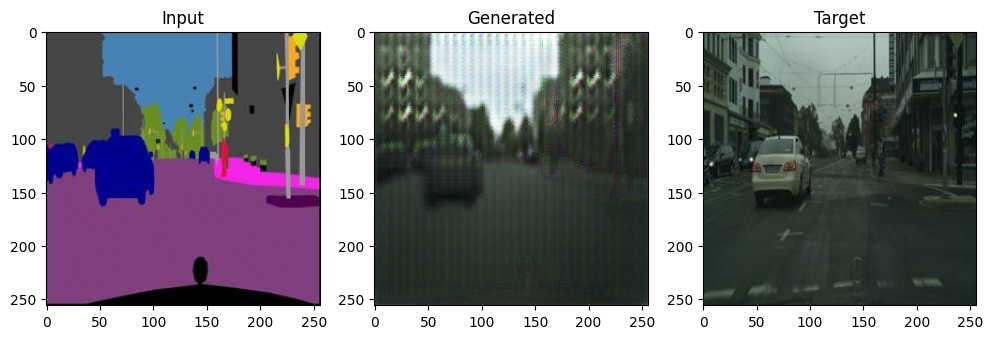

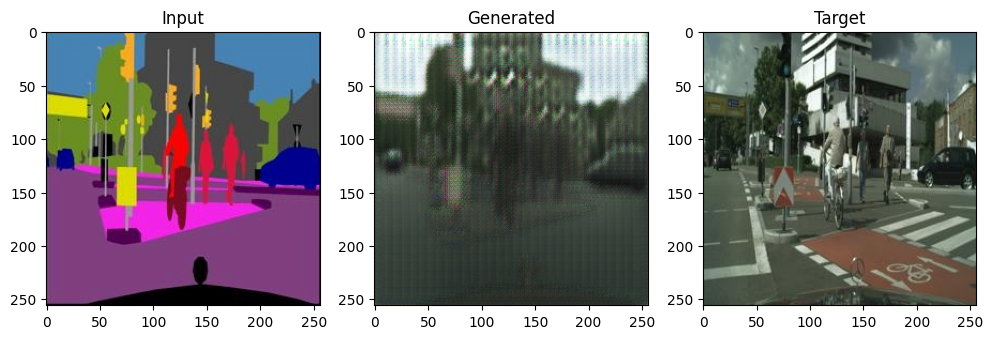

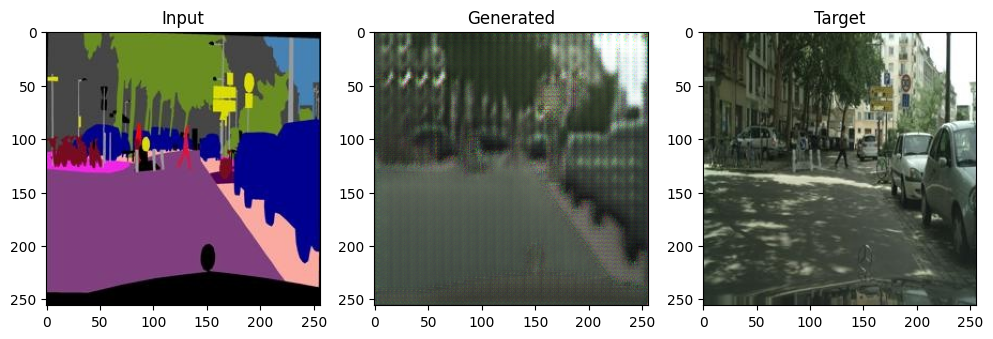

Epoch [11/50], Generator Loss: 22.95716094970703, Discriminator Loss: 1.2618634700775146
Epoch [12/50], Generator Loss: 21.139463424682617, Discriminator Loss: 0.21089915931224823
Epoch [13/50], Generator Loss: 20.74791717529297, Discriminator Loss: 0.49042457342147827
Epoch [14/50], Generator Loss: 21.380950927734375, Discriminator Loss: 0.6040478348731995
Epoch [15/50], Generator Loss: 20.292566299438477, Discriminator Loss: 0.34645575284957886
Epoch [16/50], Generator Loss: 19.006378173828125, Discriminator Loss: 0.6792987585067749
Epoch [17/50], Generator Loss: 22.677915573120117, Discriminator Loss: 0.7836559414863586
Epoch [18/50], Generator Loss: 19.29336929321289, Discriminator Loss: 0.5910568237304688
Epoch [19/50], Generator Loss: 18.70967674255371, Discriminator Loss: 0.6345428228378296
Epoch [20/50], Generator Loss: 18.27379608154297, Discriminator Loss: 0.9996030330657959


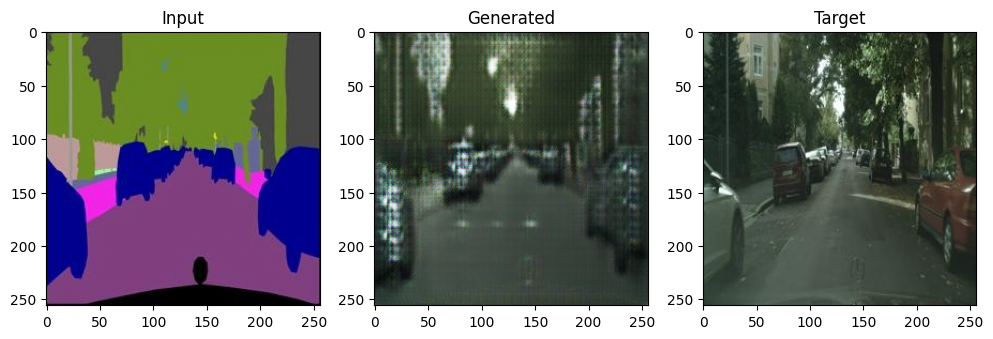

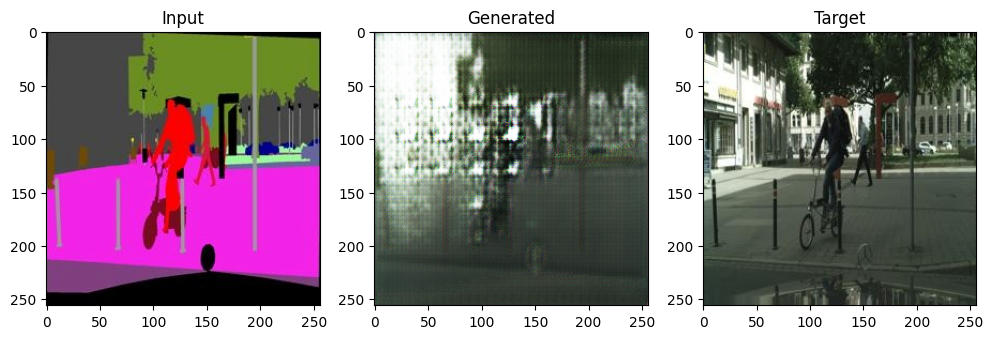

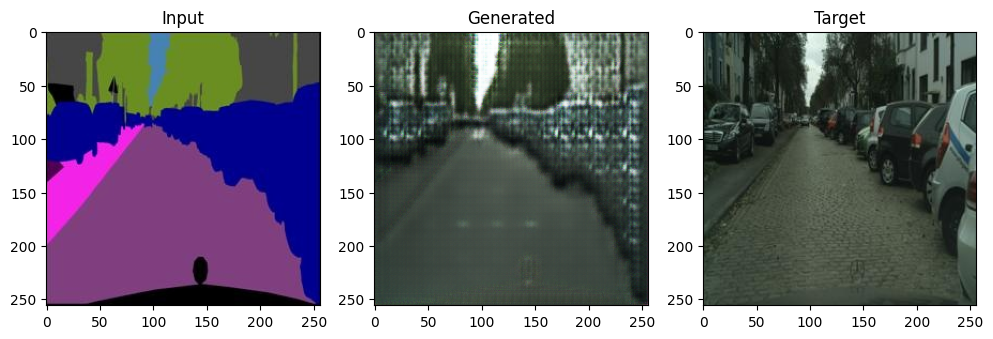

Epoch [21/50], Generator Loss: 19.592151641845703, Discriminator Loss: 0.35566723346710205
Epoch [22/50], Generator Loss: 19.331127166748047, Discriminator Loss: 0.623136579990387
Epoch [23/50], Generator Loss: 18.678956985473633, Discriminator Loss: 0.5746341943740845
Epoch [24/50], Generator Loss: 16.89603042602539, Discriminator Loss: 0.6403377652168274
Epoch [25/50], Generator Loss: 18.251920700073242, Discriminator Loss: 0.4072266221046448
Epoch [26/50], Generator Loss: 18.616636276245117, Discriminator Loss: 0.737984836101532
Epoch [27/50], Generator Loss: 16.858558654785156, Discriminator Loss: 0.5638700723648071
Epoch [28/50], Generator Loss: 17.849092483520508, Discriminator Loss: 0.6846972703933716
Epoch [29/50], Generator Loss: 16.059999465942383, Discriminator Loss: 0.9884148836135864
Epoch [30/50], Generator Loss: 17.060672760009766, Discriminator Loss: 0.45757099986076355


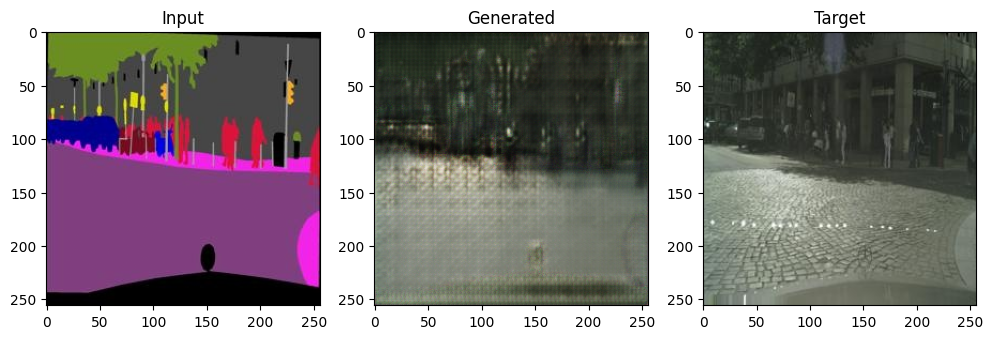

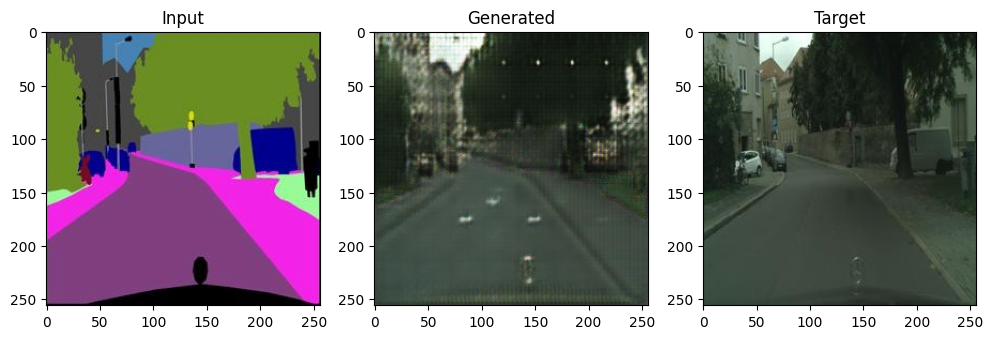

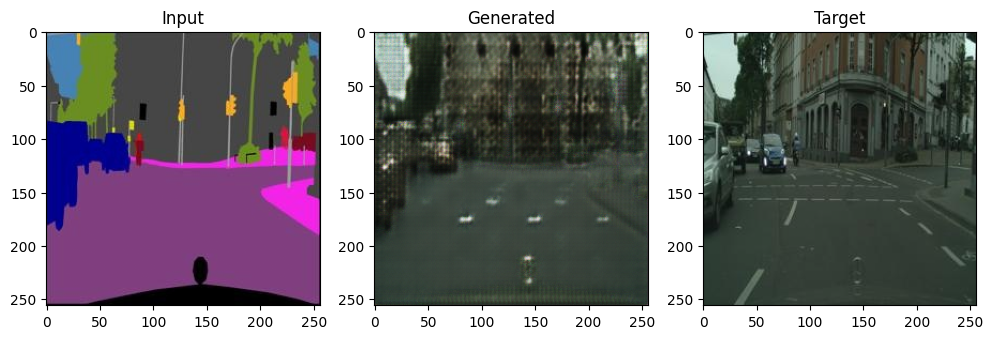

Epoch [31/50], Generator Loss: 16.83636474609375, Discriminator Loss: 0.7374706864356995
Epoch [32/50], Generator Loss: 17.386890411376953, Discriminator Loss: 0.5613594055175781
Epoch [33/50], Generator Loss: 17.219375610351562, Discriminator Loss: 0.5034305453300476
Epoch [34/50], Generator Loss: 16.255525588989258, Discriminator Loss: 0.9157235026359558
Epoch [35/50], Generator Loss: 15.541707992553711, Discriminator Loss: 0.26712751388549805
Epoch [36/50], Generator Loss: 15.742454528808594, Discriminator Loss: 0.938919723033905
Epoch [37/50], Generator Loss: 16.833969116210938, Discriminator Loss: 0.5534637570381165
Epoch [38/50], Generator Loss: 15.702849388122559, Discriminator Loss: 0.5633171200752258
Epoch [39/50], Generator Loss: 14.463149070739746, Discriminator Loss: 0.8381314873695374
Epoch [40/50], Generator Loss: 16.633691787719727, Discriminator Loss: 0.5499783754348755


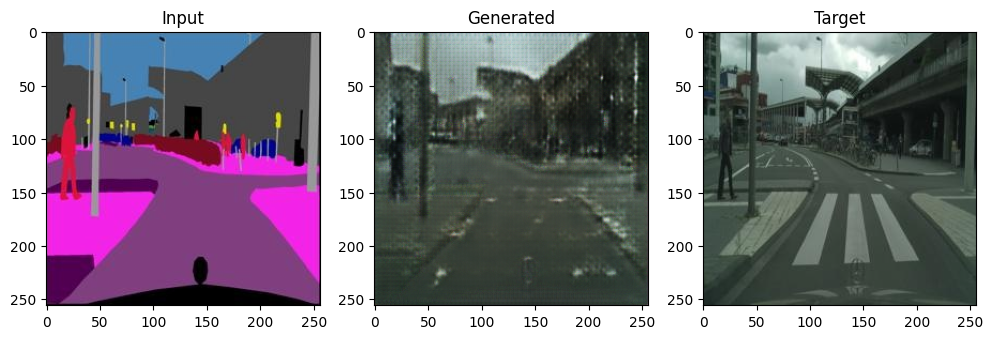

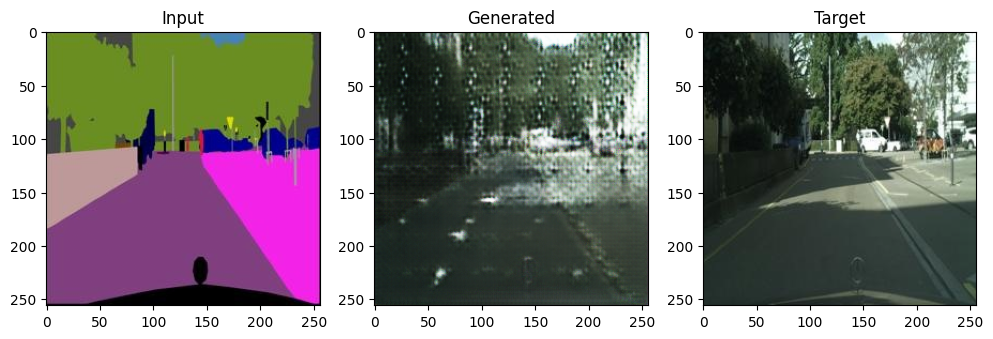

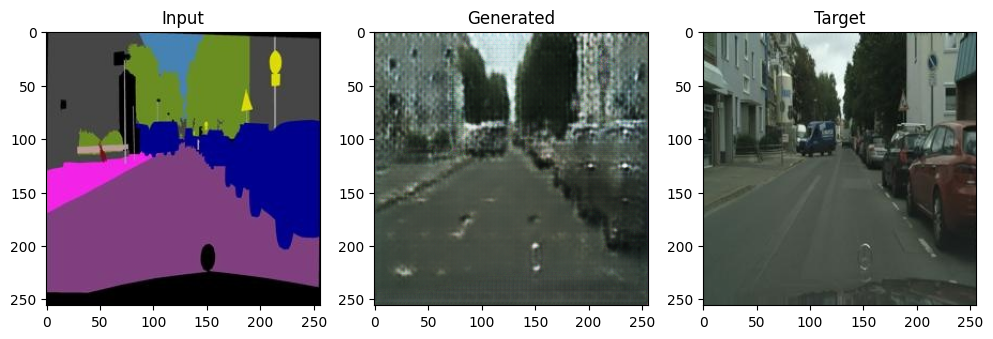

Epoch [41/50], Generator Loss: 15.827506065368652, Discriminator Loss: 0.5062098503112793
Epoch [42/50], Generator Loss: 15.386117935180664, Discriminator Loss: 0.4513890743255615
Epoch [43/50], Generator Loss: 14.091442108154297, Discriminator Loss: 0.4707244336605072
Epoch [44/50], Generator Loss: 14.746038436889648, Discriminator Loss: 0.6161950826644897
Epoch [45/50], Generator Loss: 15.427888870239258, Discriminator Loss: 0.45684313774108887
Epoch [46/50], Generator Loss: 14.570903778076172, Discriminator Loss: 0.6277645826339722
Epoch [47/50], Generator Loss: 14.529067993164062, Discriminator Loss: 0.5234228372573853
Epoch [48/50], Generator Loss: 14.408921241760254, Discriminator Loss: 0.5549821853637695
Epoch [49/50], Generator Loss: 14.461038589477539, Discriminator Loss: 0.575695276260376
Epoch [50/50], Generator Loss: 15.534407615661621, Discriminator Loss: 0.7127794027328491


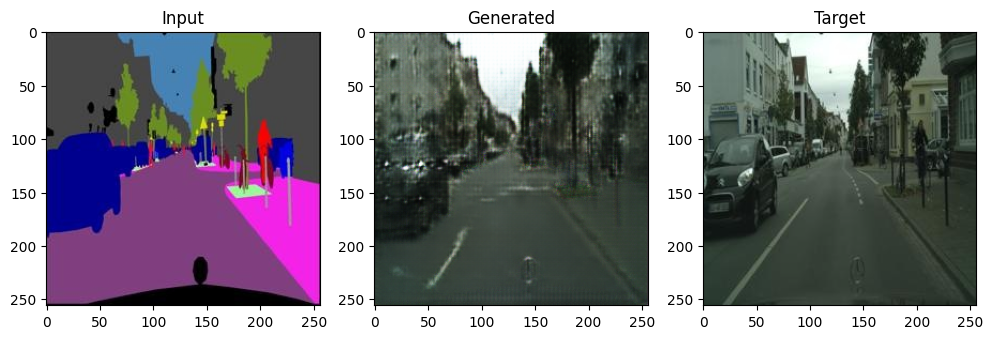

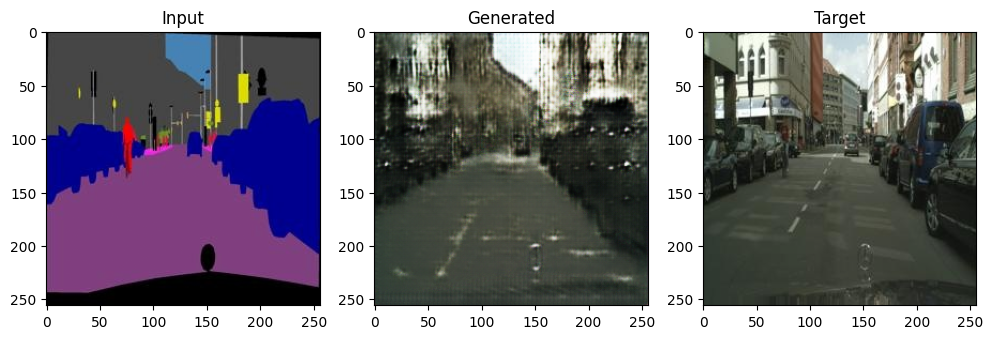

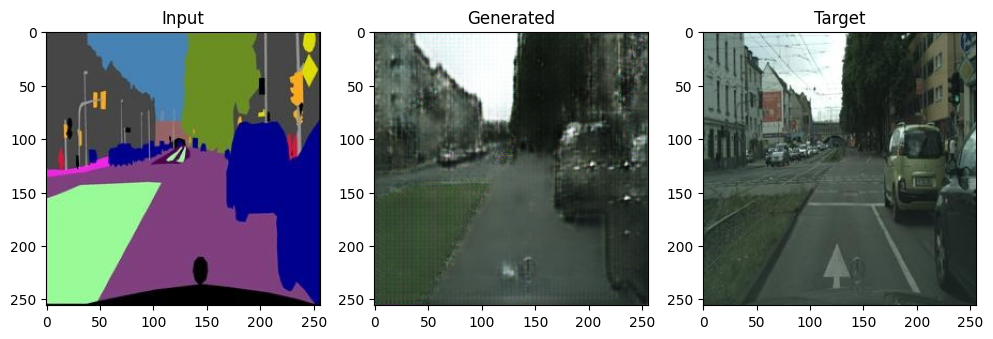

Training Complete!


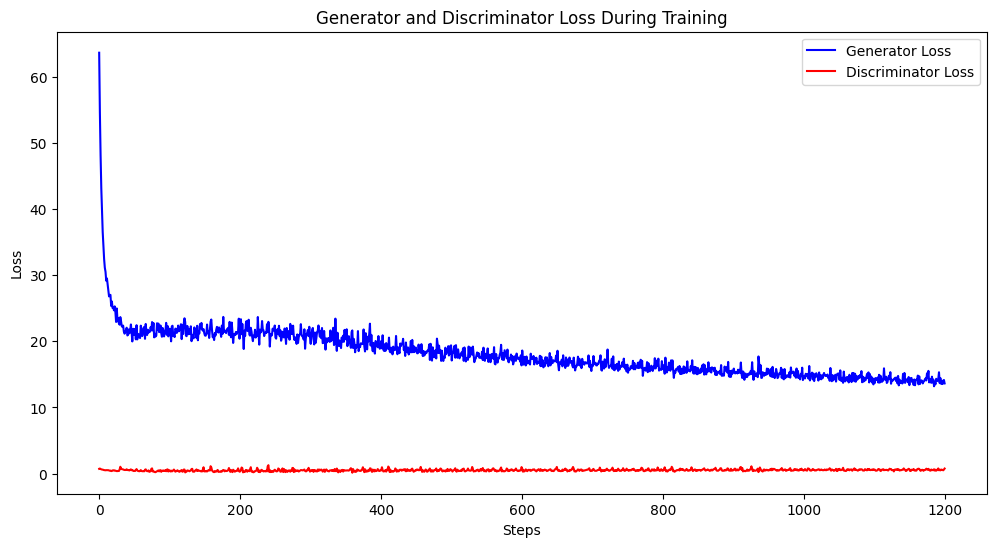

In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class Pix2PixDataset(Dataset):
    def __init__(self, root_dir , transform=None):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transform

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.root_dir , self.image_files[idx])
        
        
        input_image_pil = Image.open(input_image_path).convert("RGB")
        
        width, height = input_image_pil.size
        
        input_image_tensor = transforms.ToTensor()(input_image_pil)
        
        
        target_image = input_image_tensor[:, :, :width // 2]  # Left half
        input_image = input_image_tensor[:, :, width // 2:]  # Right half

        
        if self.transform:
            input_image = self.transform(transforms.ToPILImage()(input_image))
            target_image = self.transform(transforms.ToPILImage()(target_image))

        return input_image, target_image

    def __len__(self):
        return len(self.image_files)


transform = transforms.Compose([
    transforms.Resize((256  , 256)),
    transforms.ToTensor() ,
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 
])

batch_size = 128
train_dataset = Pix2PixDataset(root_dir=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Pix2PixDataset(root_dir=val_path, transform=transform)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

generator = Generator()
discriminator = Discriminator()


g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


loss_fn = Pix2PixLoss(lambda_L1 =  100)

train_pix2pix(generator, discriminator, train_loader, loss_fn  , g_optimizer, d_optimizer, epochs=50)


**#Result: We see that in the initial stages, the quality of the reconstructed image is very low, but the more epochs we do, the better the quality of the output images becomes. If we want the quality to be better than this, we can go up to 100 epochs, but due to memory limitations, it was not possible for me to do this or change the hyperparameters.
#According to the loss graph, we see that the loss for the Generator is decreasing with increasing epochs, but it takes a long time for the loss to decrease and the training process is not nearly stable.**

**Hyper-parameters: 
num_epoch = 50
batch_size = 128
Optimizer = Adam -> for Generator and Discriminator
betas = (0.5, 0.999) -> for Generator and Discriminator
Learning_Rate = 0.0002
lambda_L1 = 100  -> Regularization**